## 1. Module Import, Select Device, and Download MNIST Data

### 1-1. Setup & Module Import

In [1]:
!pip install qiskit[visualization]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# from torchsummary import summary

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit.random import random_circuit

from itertools import combinations

### 1-2. Select Device

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)
print('cuda index:', torch.cuda.current_device())
print('GPU 이름:', torch.cuda.get_device_name())

Using PyTorch version: 1.9.0+cu102  Device: cuda
cuda index: 0
GPU 이름: Tesla T4


### 1-3. Setting of the main hyper-parameters of the model

In [4]:
BATCH_SIZE = 256
EPOCHS = 10     # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
seed = 47
np.random.seed(seed)        # Seed for NumPy random number generator
torch.manual_seed(seed)     # Seed for TensorFlow random number generator

backend = qiskit.Aer.get_backend('aer_simulator')
shots = 100
shift = 0.5

### 1-4. Data Loading

In [5]:
train_dataset = datasets.MNIST(root = "./data",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "./data",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([256, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([256]) type: torch.LongTensor


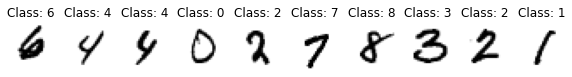

In [7]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))



## 2. Construct Quantum Circuit

### 2-1. Create a 'Quantum Class' with Qiskit

In [8]:
class RandomCircuit:
    """ 
    This class defines random circuit of Quanvolution layer
    """
                      
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.n_qubits = n_qubits
        self._circuit = qiskit.QuantumCircuit(self.n_qubits)

        depth = np.random.randint(1,7,1)[0]
                                                  
        #self.theta = qiskit.circuit.Parameter('theta')
        self.theta = [qiskit.circuit.Parameter('theta{}'.format(i)) for i in range(self.n_qubits)]

        for i in range(self.n_qubits):                                                                  
            self._circuit.ry(self.theta[i], i)

        self._circuit.barrier()
        self._circuit += random_circuit(self.n_qubits, depth)                                                                                                  
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
                                                                                                                                              
    def run(self, data):
        param_dict = dict()
        for i in range(self.n_qubits):
            param_dict[self.theta[i]] = data[i] * np.pi / 255

        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [param_dict])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
                                                                                                                                                                                                                                                                   
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
                                                                                                                                                                                                                                                                                           
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities) / np.pi
                                                                                                                                                                                                                                                                                                                                   
        return expectation

Let's test the implementation.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
/usr/local/lib/python3.7/dist-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


57.62682179471347


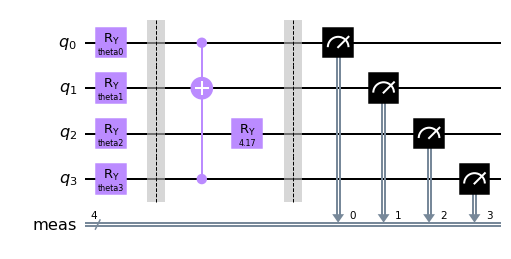

In [9]:
simulator = backend

circuit = RandomCircuit(4, simulator, shots)
#print('Expected value for rotation pi {}'.format(circuit.run([np.pi, np.pi*2])[0]))
print(circuit.run(np.random.randint(0, 255, size=4)))
circuit._circuit.draw('mpl')

### 2-2. Create a 'Quanvolution Class' with PyTorch

In [10]:
import time

In [11]:
class QuanvFunction(Function):
    """ Hybrid quantum - classical function definition """
    """
    Convolves the input image with many applications of the same quantum circuit.
    In the standard language of CNN, this would correspond to a convolution with a stride equal to 1.
    """

    @staticmethod
    def forward(ctx, input, quantum_circuits, in_channels, out_channels, kernel_size, backend, shots, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuits = quantum_circuits

        input_size = input.size()[-1]
        output_size = input_size - 2 * (kernel_size // 2)

        output = torch.zeros((BATCH_SIZE, out_channels, output_size, output_size))
        multiplier = out_channels // in_channels

        for i, image in enumerate(input):
            start = time.time()
            for m in range(multiplier):
                for c in range(in_channels):
                    for x in range(output_size):
                        for y in range(output_size):
                            window = image[c, x:x+kernel_size, y:y+kernel_size].squeeze()
                            window_flatten = window.reshape(kernel_size ** 2)
                            output[i, m*in_channels+c, x, y] = quantum_circuits[m].run(window_flatten.numpy())
                            #print(i, m*in_channels+c, x, y)
            print(i,"번 이미지 처리 시간: ", time.time()-start)

        result = output
        ctx.save_for_backward(input, result)

        return result
                                                                                  
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, result = ctx.saved_tensors
        input_list = input.numpy()
                                                                                                                          
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
                                                                                                                                                  
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
                                                                                                                                                                                                      
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])  # Actually (gradient * shift * 2), but that doesn't matter
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

In [12]:
class Quanv(nn.Module):
    """ Quanvolutional layer definition """

    def __init__(self, circuit_type, in_channels, out_channels, kernel_size, backend=backend, shots=shots, shift=shift):
        super(Quanv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        multiplier = out_channels // in_channels

        if out_channels % in_channels != 0:
            print("out_channels / in_channels must be an integer")
            raise NotImplementedError

        if circuit_type == 'random':
            self.quantum_circuits = [RandomCircuit(n_qubits=kernel_size**2, 
                                                   backend=backend, 
                                                   shots=shots) for c in range(multiplier)]
        else:
            print("Invalid circuit_type")
            raise NotImplementedError

        self.kernel_size = kernel_size
        self.backend = backend
        self.shots = shots
        self.shift = shift
    
    def forward(self, input):
        return QuanvFunction.apply(input, self.quantum_circuits, 
                                   self.in_channels, self.out_channels, 
                                   self.kernel_size, self.backend, 
                                   self.shots, self.shift)

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.quanv = Quanv('random', 1, 1, kernel_size=3)
        self.conv = nn.Conv2d(1, 16, kernel_size=3)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.quanv(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x)

In [14]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculating loss
        loss = loss_func(output, target)
        
        # Backward pass
        loss.backward()
        
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))


0 번 이미지 처리 시간:  5.695739269256592
1 번 이미지 처리 시간:  5.56649112701416
2 번 이미지 처리 시간:  5.5521464347839355
3 번 이미지 처리 시간:  5.4365880489349365
4 번 이미지 처리 시간:  5.727712392807007
5 번 이미지 처리 시간:  5.608194828033447
6 번 이미지 처리 시간:  5.465724468231201
7 번 이미지 처리 시간:  5.541659355163574
8 번 이미지 처리 시간:  5.648494482040405
9 번 이미지 처리 시간:  5.482283592224121


KeyboardInterrupt: ignored

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.cuda()
        target = target.cuda()
        output = model(data).cuda()
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = loss_func(output, target)
        total_loss.append(loss.item())
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100 / batch_size)
        )